In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import earthaccess
import joblib
import json
import pandas as pd
from shapely.geometry import shape
import xarray as xr
from typing import Dict, Any
import fsspec
from pystac_client import Client

import data_classes


In [2]:
# Load model
model = joblib.load('random_forest_model.pkl')

# Load scalers
X_scaler = joblib.load('X_scaler.pkl')
Y_scaler = joblib.load('Y_scaler.pkl')

In [3]:
with open('ski_areas.geojson', 'r') as f:
    ski_areas = json.load(f)


In [4]:
def is_wa_ski_site(area):
    return area['properties']['location'] and area['properties']['location']['iso3166_2'] == 'US-WA' and area['geometry']['type'] != 'Point'
wa_ski_sites = [area for area in ski_areas['features'] if is_wa_ski_site(area)]

len(wa_ski_sites)

17

In [5]:
crystal_mountain_area = [site for site in wa_ski_sites if site['properties']['name'] == 'Crystal Mountain'][0]
# crystal_mountain_area

In [6]:
# Alternative: Get bounds directly from shapely geometry
crystal_polygon = shape(crystal_mountain_area['geometry'])
crystal_bounds = crystal_polygon.bounds  # Returns (minx, miny, maxx, maxy)

print(f"\nDirect bounds: {crystal_bounds}")


Direct bounds: (-121.5089145, 46.90889530000001, -121.46718410000003, 46.9567407)


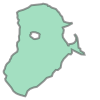

In [7]:
crystal_polygon

In [9]:
stac_api = "https://landsatlook.usgs.gov/stac-server"
collections =  ["landsat-c2ard-sr"] # "landsat-c2l3-fsca" will also be used for snow cover fraction
fs = fsspec.filesystem("s3", anon=False, requester_pays=True)
start_date, end_date = '2002-01-01', '2002-12-31'

In [10]:
client = Client.open(stac_api)
landsat_item_search = client.search(
    collections=collections,
    bbox=crystal_bounds,
    datetime=(start_date, end_date)
)

landsat_item_search.matched()

74

In [11]:
landsat_items = landsat_item_search.item_collection()

In [12]:
def process_item_parallel(args: tuple) -> Dict[str, Any]:
    """Process a single item in parallel"""
    fs, item, polygon = args
    extractor = data_classes.HLSDataExtractor(fs=fs, item=item)
    manager = data_classes.SatelliteDataManager(
        extractor=extractor
    )    
    return manager.extract_inference_data(polygon)


In [21]:
max_workers = 8
def run_in_parallel(function, tasks):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_task = {executor.submit(function, task): task for task in tasks}
        for future in as_completed(future_to_task):
            result = future.result()
            if result is not None:
                results.append(result)
    return pd.concat(results)

In [20]:
# %%time
# # for testing
# result = process_item_parallel((fs, landsat_items[2], crystal_polygon))

In [49]:
%%time
tasks = [(fs, item, crystal_polygon) for item in landsat_items]
results = run_in_parallel(process_item_parallel, tasks)

CPU times: user 4min 26s, sys: 1min 28s, total: 5min 55s
Wall time: 3min 13s


In [50]:
results.shape

(630852, 11)

In [51]:
results['datetime'] = pd.to_datetime(results['time'])
results['day'] = results['datetime'].dt.day
results['month'] = results['datetime'].dt.month
results['year'] = results['datetime'].dt.year
results.loc[~results['fsca'].between(0, 1000), 'fsca'] = None

In [52]:
results.describe()

,longitude,latitude,coastal,blue,green,red,nir08,swir16,swir22,fsca,day,month,year
count,630852.000000,630852.000000,0.0,630852.000000,630852.000000,630852.000000,630852.000000,630852.000000,630852.000000,524352.000000,630852.000000,630852.000000,630852.0
mean,-121.491116,46.933597,NaN,31460.181854,26585.948612,28159.311715,24545.407612,16100.925238,13680.065372,408.607716,15.837261,6.875292,2002.0
std,0.008397,0.011751,NaN,24245.510591,19555.575797,21218.967744,11320.439494,8574.904446,5310.561996,389.966851,8.704773,3.360576,0.0
min,-121.508679,46.909031,NaN,6826.000000,6750.000000,6584.000000,7438.000000,6703.000000,6752.000000,0.000000,1.000000,1.000000,2002.0
25%,-121.497901,46.923981,NaN,9280.000000,10195.000000,10476.000000,15803.000000,10538.000000,9364.000000,0.000000,9.000000,4.000000,2002.0
50%,-121.491643,46.933020,NaN,20802.000000,20712.000000,20550.000000,21848.000000,14534.000000,12671.000000,330.000000,17.000000,7.000000,2002.0
75%,-121.484690,46.943798,NaN,65535.000000,34267.000000,35476.000000,31775.250000,18833.000000,16591.000000,754.000000,23.000000,10.000000,2002.0
max,-121.467306,46.956662,NaN,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,65535.000000,1000.000000,31.000000,12.000000,2002.0


In [53]:

input_columns = ["red", "green", "blue", "coastal", "nir08", "swir16", "swir22", "fsca", "latitude", "longitude", "month"]
x_input_data = results[input_columns]
x_scaled = X_scaler.transform(x_input_data)


In [54]:
y_pred = model.predict(x_scaled)
y_pred

array([0.25599942, 0.26109488, 0.17265745, ..., 0.34875576, 0.34428572,
       0.35387097], shape=(630852,))

In [55]:
y_scaled = Y_scaler.inverse_transform([[pred] for pred in y_pred])
y_scaled

array([[55.5518751 ],
       [56.65758959],
       [37.46666684],
       ...,
       [75.67999999],
       [74.71000033],
       [76.78999955]], shape=(630852, 1))

In [56]:
results['snow_depth_prediction'] = y_scaled

In [57]:
results.shape

(630852, 16)

In [62]:
# get average snow depth over the resort area from all pixels available for a given month-year
results_grouped = results.groupby(['month', 'year']).agg({'snow_depth_prediction': 'mean'})

<Axes: xlabel='month,year'>

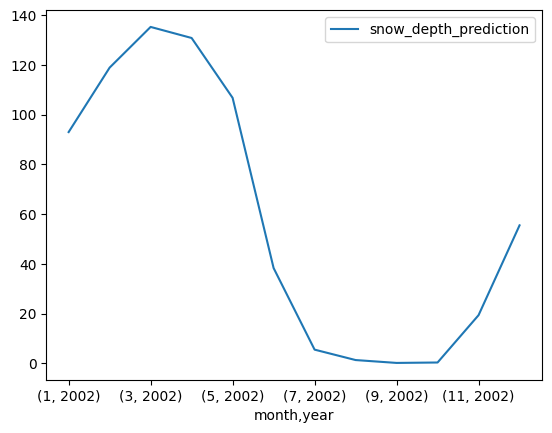

In [63]:
results_grouped.plot()

In [ ]:
# what we have a matrix of observations, identified by datetime and a snow depth prediction for each pixel.
# We can multiply those by the size of each pixel to get the area of snow.
# Then we can sum those up to get the total area of snow for each year.
area_of_each_pixel = 30 * 30
reduced_pixels_df['snow_volume_prediction'] = reduced_pixels_df['snow_depth_prediction'] * area_of_each_pixel
reduced_pixels_df['snow_volume_prediction']

0       51290.999885
1       51974.999732
2       57762.000168
3       52253.999831
4       57474.000139
            ...     
8645    65538.000248
8646    65556.000281
8647    65340.000237
8648    66456.000258
8649    65556.000281
Name: snow_volume_prediction, Length: 8650, dtype: float64